# Introduction
This project aims to compare different approaches to movie recommendation based on historical ratings of users.
Each model is tested in predicting the rating for a given user and movie pair.
Available ratings are split into training and testing subsets. Models are scored based on accuracy of their predictions with respect to ratings in the training set.
I chose the MovieLens data set as I was also curious how the models scale with amount of data, both in their accuracy and computational requirements.

# Data set
The data set contains ratings of movies by users, in the form of records `(rating, movieId, userId)`.
The ratings are given as a number in range $[0.5, 5.0]$.
The data set is available in two sizes: `~100k` ratings and `~25m` ratings.
These ratings are distributed among `~53k` different movies and are given by `~283k` users.
The records are transformed into sparse utility matrix with ratings as elements and user and movie ids as axes.
The sparse storage is dictated by huge dimensions of the matrix coupled with sparsity of ratings (0.2 % non-zero entries in large data set).
Aside from using utility matrix as is, I normalized it by subtracting for each user (movie) their average score from non-zero entries in respective row (column) of utility matrix.
In order to retain numerical stability in later processing I added small ($\epsilon = 0.001$) amount to each rating, such that no row or column would become all zeroes.
Conceptually this normaliztion assigns average rating as the initial prediction.
Additionally I checked how restricting the dataset by requiring minimal amount of ratings for a movie affects the algorithms.

In [12]:
def desc(name, size):    
    ratings = read_files(size=size)[0]
    users = ratings.groupby(f"{name}Id")['rating'].count()
    user_count = len(users.index)
    user_stats = users.describe()

    return f"{name}_{size}", user_stats

stats = [desc('user', 'small'),
         desc('movie', 'small'),
         desc('user', 'big'),
         desc('movie', 'big')
        ]
stats = pd.DataFrame(dict(stats), dtype='int64').drop('std')
stats

,user_small,movie_small,user_big,movie_big
count,610,9724,283228,53889
mean,165,10,97,515
min,20,1,1,1
25%,35,1,15,2
50%,70,3,30,7
75%,168,9,95,48
max,2698,329,23715,97999


# Collaborative Filtering
Collaborative Filtering is a technique that attempts to predict unknown ratings by using known ratings of similar items.
It comes in two flavours:
1. `Item-item` - rating is predicted based on ratings of other similar movies rated by a given user.
2. `User-user` - rating is predicted based on ratings of a given movie rated by other similar users.

In this project I chose `item-item` approach for two reasons.
Firstly, according to literature it gives more stable results over time, as user tastes may change.
Secondly, the similarity matrix for movies is about 100 times smaller than for users (which would not fit in memory of my computer).
I tested two approaches to aggregating the users: Weighted Average and K-Most Similar Average.
Both of them use precomputed similarity matrix.
I chose cosine similarity as it is recommended by literature and can be precomputed using sparse matrix multiplication.
The result is stored as a dense matrix to facilitate faster access.

## Weighted Average
In this variant all ratings that have been found are aggregated by computing their average weighted by similarity.

\begin{align*}
    r_m^u =& \frac{\sum_{m' \in M_u} r_{m'}^u s_m^{m'}}{\sum_{m' \in M_u} s_m^{m'}} \\
    M_u =& \text{ set of movies rated by } u \\
    s_m^{m'} =& \text{ similarity of } m \text{ and } m'
\end{align*}

## K-Most Similar
This approach aggregates ratings, by taking average rating of $k$ most similar movies.


# Singular Value Decomposition

Another approach to ranking prediction is learning latent relationships between users and items.
Using Singular Value Decomposition, the utility matrix is decomposed into three matrices of lower dimension, parameterized by $k$.
\begin{align*}
    R = & U \Sigma V^T \\
    U \in & \mathbb{R}^{m \times k} \\
    \Sigma \in & \mathbb{R}^{k \times k} \\
    V^T \in & \mathbb{R}^{k \times n}
\end{align*}
To predict the rating of a movie $m$ by an user $u$ it suffices to calculate $U_{(m)} \Sigma (V^T)^{(u)}$

# Results
I measured mean squared error of predicted rating compared to given rating in the testing set.

In general Collaborative Filtering with K-Most Similar aggregation performed the best, particularly when ratings were normalized by average movie rating.
Unfortunately it was also the slowest method, but I suspect it may be due to suboptimal implementation.

The Weighted Average performed the worst on small data set and didn't work with normalized ratings.
I suspect, that it may be due to low amount of ratings per movie (less than 10 for majority of movies) and resulting numerical instabilities in weight calculation.
On large data set however, it performed quite well on data normalized by average movie rating.

Singular Value Decomposition gave stable results both for small and large data sets.
It's accuracy was worse than KMS but it was the fastest algorithm and it had smallest memory footprint.

Restricting the set of movies based on minimal count of ratings improved the accuracy of all algorithms, especially when the data was also normalized by average movie rating.

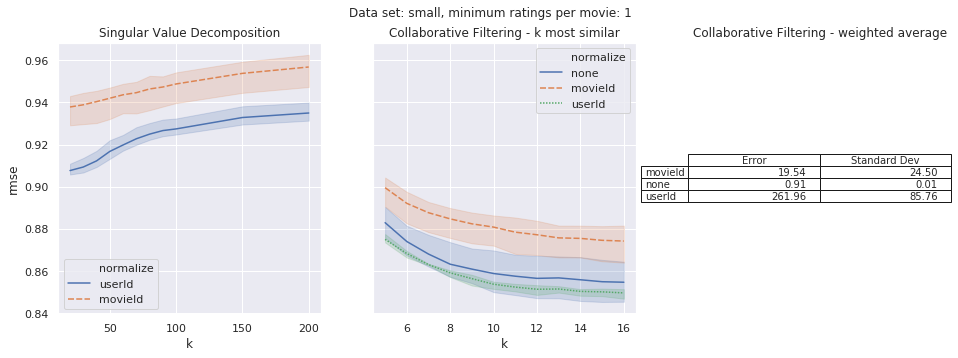

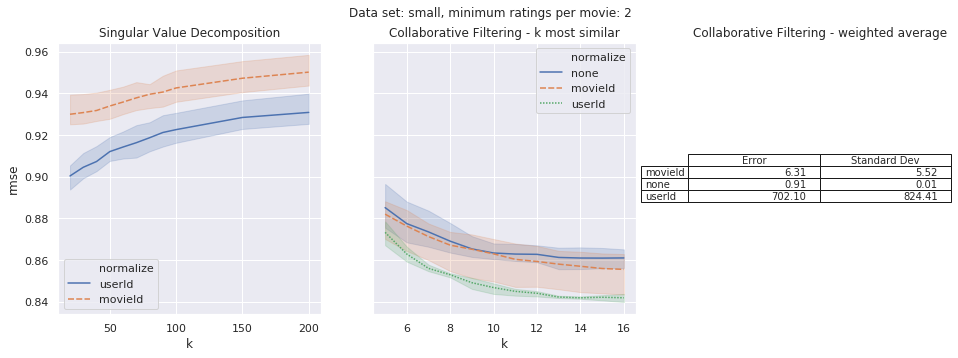

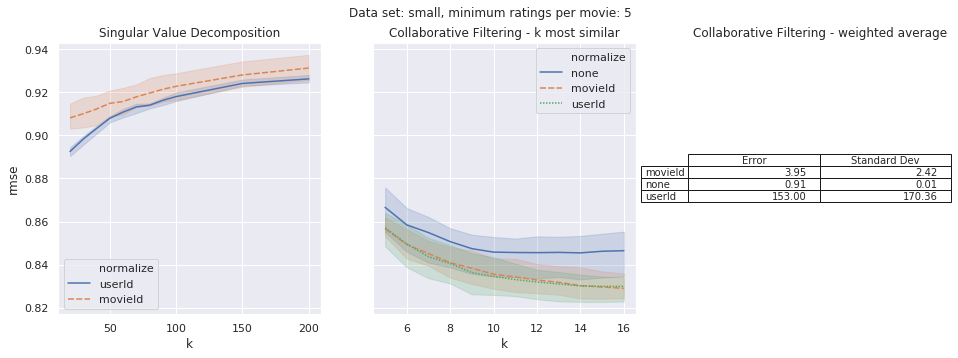

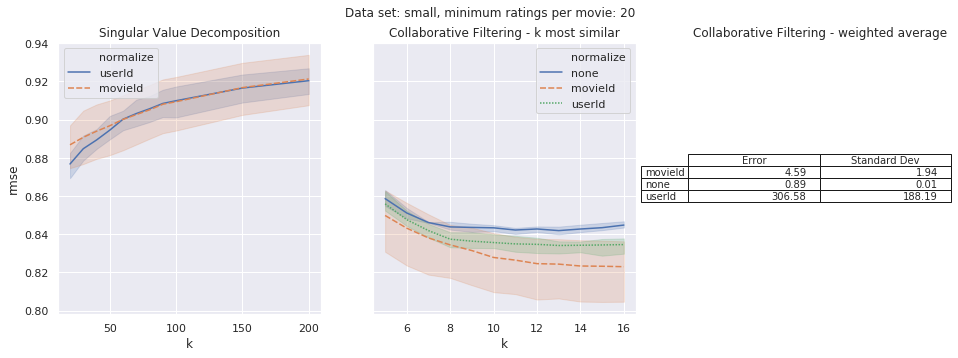

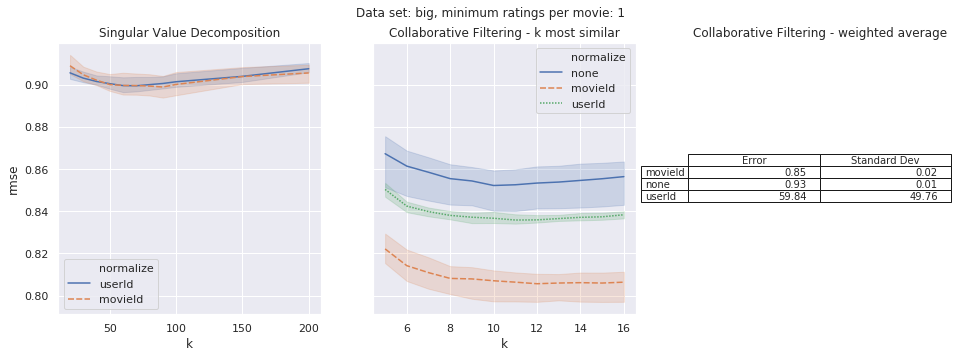

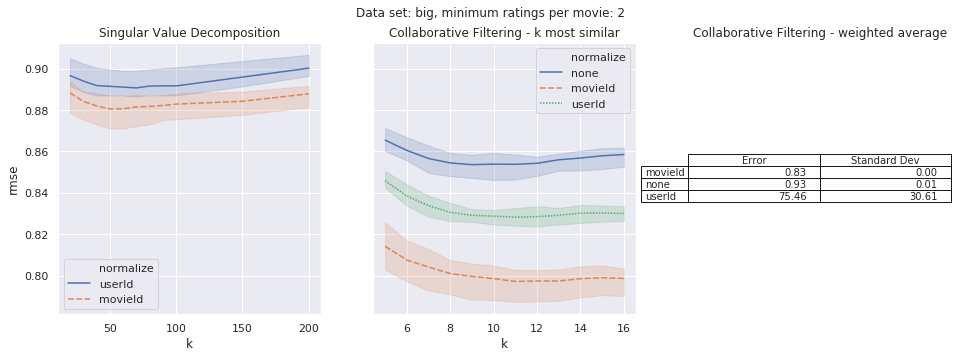

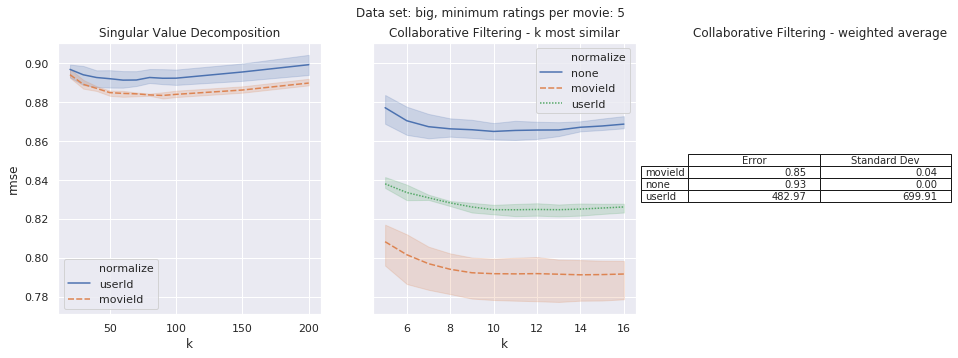

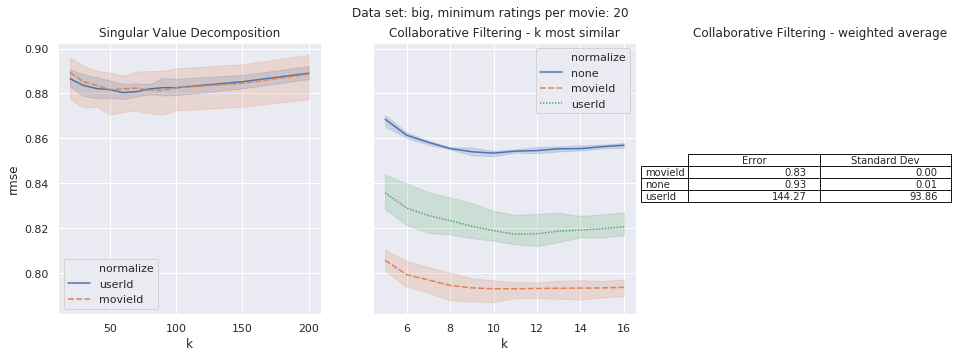

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

for size in ['small', 'big']:
    for min_ratings in [1, 2, 5, 20]:
        svd = pd.read_csv(f"svd-{size}-{min_ratings}.csv")
        cf = pd.read_csv(f"cf-{size}-{min_ratings}.csv")
        knn = pd.read_csv(f"knn-{size}-{min_ratings}.csv")
        fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=[16, 5])
        fig.suptitle(f"Data set: {size}, minimum ratings per movie: {min_ratings}")
        axes[0].set_title("Singular Value Decomposition")
        sns.lineplot(ax=axes[0], data=svd, x='k', y='rmse', hue='normalize', style='normalize')
        axes[1].set_title("Collaborative Filtering - k most similar")
        sns.lineplot(ax=axes[1], data=knn, x='k', y='rmse', hue='normalize', style='normalize')
        cf = cf.groupby('normalize')
        fmt = lambda x: f"{x:.2f}"
        text = np.array([cf.mean().rmse.map(fmt), cf.std().rmse.map(fmt)]).T
        axes[2].axis('off')
        axes[2].set_title('Collaborative Filtering - weighted average')
        axes[2].table(
            cellText=text,
            rowLabels=cf.count().index,
            colLabels=['Error', 'Standard Dev'],
            loc='center'
        )